In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
from helper_functions import *

# Benchmarking:

January 2, 1991 to April 30, 2018

- DJIA  
* First 4500 days is training
* Next 1300 days is validation
* The rest is testing

In [22]:
####### EXPERIMENT DEPENDENT
WINDOW_SIZE = 20  # SAME AS ZHANG ET AL.

####### DO NOT CHANGE BELOW
TRAIN_END = 4500
VAL_END = 4500 + 1300
SEQ_LEN = WINDOW_SIZE


## DJIA

In [23]:
PATH = "^DJI1991_2018.csv"
df = pd.read_csv(PATH, index_col = 'Date', parse_dates=True)
df.head(5) ; print(len(df))

6631


### **Modify all input columns into residual**

**Use previous day columns (including closing price) to predict next day results**

In [24]:
print(len(df))
X = apply_residual_change(df); print(X.shape);
y = apply_residual_change(df['Close']); print(y.shape)

X, y = build_base_X_y_difference(X, y); print(X.shape, y.shape)

y = y.reshape(-1, 1)

assert X.shape[0] == len(df)-2, "ERROR: SOME OPERATION ERROR DURING DATA ENGINEERING"
assert X.shape[0] == y.shape[0], "ERROR : X AND y HAVE DIFFERENT LEN"

USABLE_DATA_LEN = X.shape[0]

6631
(6630, 6)
(6630,)
6629 6629
(6629, 6) (6629,)


Transform the data to between 0 - 1 so the network converges faster

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()     # minMax on the y for quicker learning. More suitable than SS

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(y) 

##### Train_val_test

In [26]:
X_train_tensors_final, X_val_tensors_final, X_test_tensors_final, \
    y_train_tensors, y_val_tensors, y_test_tensors = create_datatensors(X_mm, y_mm)

In [27]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_val_tensors_final.shape, y_val_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([4500, 20, 6]) torch.Size([4500, 1])
Testing Shape torch.Size([1300, 20, 6]) torch.Size([1300, 1])
Testing Shape torch.Size([809, 20, 6]) torch.Size([809, 1])


In [28]:
a = len(X_test_tensors_final) + len(X_train_tensors_final) + len(X_val_tensors_final)
b = len(y_test_tensors) + len(y_train_tensors) + len(y_val_tensors)
assert a == b, "X AND Y UNEQUAL LEN"

USABLE_DATA_LEN =  len(X_test_tensors_final) + len(X_train_tensors_final) + len(X_val_tensors_final)

#### GridSearch

In [29]:
model_params = {
        'input_size': 6,
        'num_layers': 1,
        'num_classes': 1,
        'criterion': torch.nn.MSELoss(),
        'learning_rate': 0.001,
        'hidden_sizes': [5, 15, 30],
        'lookback': [1, 5, 10],
        'sequence_len': 20
    }

model = 'lstm'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

lstm_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 12 with validation loss: 0.0030750219096861236
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 12 with validation loss: 0.0030774635748324415
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 11 with validation loss: 0.0030809647060090267
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 11 with validation loss: 0.003083178472546179
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 14 with validation loss: 0.0030900623490352458
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 18 with validation loss: 0.003096156070724402
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 19 with validation loss: 0.0031002920969934542
#-------------------------
Now running model: Hidden-size 15, 

##### Inverse compute Price Graph

How to compute?

Since we will **always** have access to the figures from yesterday, it means we will multiply the previous day 'Close' price with the predicted ratio.

In [30]:
# Create Dicts to store results
days_1 = dict()
days_3 = dict()
days_7 = dict()

In [31]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  lstm

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 25911.685790
MAE: 109.015798
RMSE: 160.971071
MAPE: 14.776665

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 26525.366931
MAE: 109.795755
RMSE: 162.866101
MAPE: 0.565652


In [32]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 8099.274320
MAE: 62.127983
RMSE: 89.995968
MAPE: 0.318137


In [33]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 3418.565435
MAE: 41.419315
RMSE: 58.468500
MAPE: 0.211605


##### plots

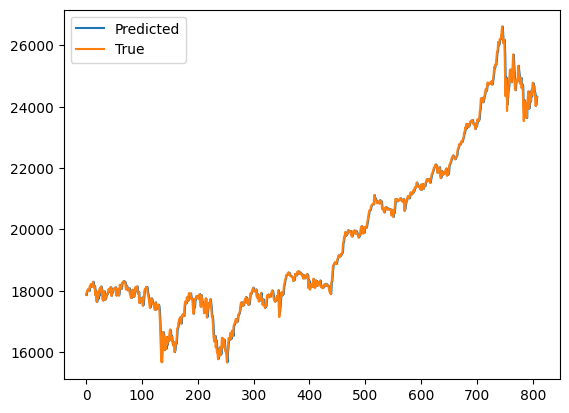

In [34]:
plt.plot(result, label = 'Predicted')
plt.plot(y_groundtruth, label = 'True')
plt.legend()
plt.show()

## RNN

##### RNN

In [35]:
# use the same parameters as above
#
model = 'rnn'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

rnn_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 53 with validation loss: 0.003109628009530375
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 11 with validation loss: 0.003126618767543355
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 11 with validation loss: 0.0031682957466351003
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 11 with validation loss: 0.0031737828394398093
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 14 with validation loss: 0.003195280265971655
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 12 with validation loss: 0.0032060077575762277
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 11 with validation loss: 0.003220192335614162
#-------------------------
Now running model: Hidden-size 15,  l

In [36]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  rnn

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 28410.549331
MAE: 115.362724
RMSE: 168.554292
MAPE: 14.767986

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 26525.366931
MAE: 109.795755
RMSE: 162.866101
MAPE: 0.565652


In [37]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 8478.803478
MAE: 64.948788
RMSE: 92.080419
MAPE: 0.332697


In [38]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 3715.980535
MAE: 45.121991
RMSE: 60.958843
MAPE: 0.229660


## GRU

In [39]:
# use the same parameters as above
#
model = 'gru'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

gru_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 37 with validation loss: 0.0031146869622738806
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 12 with validation loss: 0.0031322423104628377
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 11 with validation loss: 0.0031806074406542794
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 15 with validation loss: 0.003205749742891185
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 24 with validation loss: 0.0032268549321310186
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 19 with validation loss: 0.0032431441387615915
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 20 with validation loss: 0.003257381440163022
#-------------------------
Now running model: Hidden-size 15, 

In [40]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  gru

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 28333.846864
MAE: 116.380810
RMSE: 168.326608
MAPE: 14.770384

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 26525.366931
MAE: 109.795755
RMSE: 162.866101
MAPE: 0.565652


In [41]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 9052.238500
MAE: 67.235335
RMSE: 95.143253
MAPE: 0.342894


In [42]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 4046.237684
MAE: 47.501975
RMSE: 63.610044
MAPE: 0.240289


## Bi-LSTM

In [43]:
# use the same parameters 
#
model = 'blstm'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

blstm_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 50 with validation loss: 0.0030722840214943196
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 16 with validation loss: 0.0030799006429932468
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 11 with validation loss: 0.0030853577631116823
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 11 with validation loss: 0.0030948950840932565
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 19 with validation loss: 0.003100734421267833
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 11 with validation loss: 0.0031020157976166867
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 20 with validation loss: 0.0031023602677145747
#-------------------------
Now running model: Hidden-size 15,

In [44]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  blstm

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 26313.399411
MAE: 109.578382
RMSE: 162.214054
MAPE: 14.772730

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 26525.366931
MAE: 109.795755
RMSE: 162.866101
MAPE: 0.565652


In [45]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 8046.692197
MAE: 62.079220
RMSE: 89.703357
MAPE: 0.318055


In [46]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 3306.719349
MAE: 41.341636
RMSE: 57.504081
MAPE: 0.211120


## Stacked LSTM

In [47]:
#
model = 'stackedlstm'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

stackedlstm_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 49 with validation loss: 0.0030781843446808436
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 13 with validation loss: 0.0030837780327490735
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 12 with validation loss: 0.003094546958270324
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 16 with validation loss: 0.0030989571170676952
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 13 with validation loss: 0.0030966800830622273
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 12 with validation loss: 0.0031008604948022742
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 13 with validation loss: 0.003099291974383338
#-------------------------
Now running model: Hidden-size 15, 

In [48]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  stackedlstm

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 26255.604201
MAE: 110.582681
RMSE: 162.035811
MAPE: 14.767716

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 26525.366931
MAE: 109.795755
RMSE: 162.866101
MAPE: 0.565652


In [49]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 8201.706048
MAE: 63.274989
RMSE: 90.563271
MAPE: 0.324420


In [50]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 3457.887464
MAE: 43.312774
RMSE: 58.803805
MAPE: 0.220860


# Data aggregation

In [51]:
# DICTS
# days_1 = dict()
# days_3 = dict()
# days_7 = dict()

In [62]:
days1df = pd.DataFrame(days_1, index=['mse', 'mae', 'rmse', 'mape'])
days3df = pd.DataFrame(days_3, index=['mse', 'mae', 'rmse', 'mape'])
days7df = pd.DataFrame(days_7, index=['mse', 'mae', 'rmse', 'mape'])

In [60]:
def highlight_min_and_second_min(s):
    sorted_vals = sorted(s)
    min_val = sorted_vals[0]  # Get the lowest value in each row
    second_min_val = sorted_vals[1]  # Get the second lowest value in each row
    is_min = s == min_val
    is_second_min = s == second_min_val
    styles = ['font-weight: bold' if v else '' for v in is_min]
    for i, v in enumerate(is_second_min):
        if v:
            styles[i] += 'text-decoration: underline'
    return styles

styled_df = days1df.style.apply(highlight_min_and_second_min, axis=1)

# Display styled DataFrame
styled_df

,lstm,rnn,gru,blstm,stackedlstm
mse,25911.685790,28410.549331,28333.846864,26313.399411,26255.604201
mae,109.015798,115.362724,116.380810,109.578382,110.582681
rmse,160.971071,168.554292,168.326608,162.214054,162.035811
mape,14.776665,14.767986,14.770384,14.772730,14.767716


In [63]:
styled_df = days3df.style.apply(highlight_min_and_second_min, axis=1)

# Display styled DataFrame
styled_df

,lstm,rnn,gru,blstm,stackedlstm
mse,8099.274320,8478.803478,9052.238500,8046.692197,8201.706048
mae,62.127983,64.948788,67.235335,62.079220,63.274989
rmse,89.995968,92.080419,95.143253,89.703357,90.563271
mape,0.318137,0.332697,0.342894,0.318055,0.324420


In [64]:
styled_df = days7df.style.apply(highlight_min_and_second_min, axis=1)

# Display styled DataFrame
styled_df

,lstm,rnn,gru,blstm,stackedlstm
mse,3418.565435,3715.980535,4046.237684,3306.719349,3457.887464
mae,41.419315,45.121991,47.501975,41.341636,43.312774
rmse,58.468500,60.958843,63.610044,57.504081,58.803805
mape,0.211605,0.229660,0.240289,0.211120,0.220860
